<a href="https://colab.research.google.com/github/ekqlsrla/ESAA/blob/main/HW/0513_CH04_67_1011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[파이썬 머신러닝 가이드]**




---
#**06 XGBoost(eXtra Gradient Boost)**

## 1. XGBoost 개요

  1) 장점
* 뛰어난 예측 성능
* GBM 대비 빠른 수행 시간 
* 과적합 규제
* Tree pruning (나무 가지치기)
* 자체 내장된 교차 검증
* 결손값 자체 처리

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

## 2. 파이썬 래퍼 XGBoost 하이퍼 파라미터

  **1) 일반 파라미터** : 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터
  * `booster` : gbtree(tree based model) / gbliner(linear model)
  * `silent` : 디폴트 = 0, 출력 메시지를 나타내고 싶지 않은 경우 1
  * `nthread` : CPU의 실행 스레드 개수 조정

**2) 부스터 파라미터** : 트리 최적화, 부스팅, regularization 관련 파라미터
* `eta[dafault =0.3, alias : learning_rate]` : 학습률의 값 조정, 디폴트 = 0.1
* `num_boost_rounds` : n_estimator와 같은 파라미터
* `min_child_weight[default=1]` : 과적합 조절하기 위해 사용
* `gamma[default=0, alias:min_split_loss]` : 트리의 리프 토드를 추가적을 나눌 지 말지 결정할 최소 손실 감소 값
* `max_depth[default=6]` : 트리 기반 알고리즘의 max_depth
* `sub_sample[default=1]` : 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율 지정
* `colsample_bytree[default=1]` : 트리 생성에 필요한 피처를 임의로 샘플링
* `lambda[default=`,alias:reg_lambda]` : L2 Regularization 적용 값
* `alpha[default = 0, alias : reg_alpha]` : L1 Regularization 적용 값
* `scale_pos_weight[default=1]` : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터

**3) 학습 태스크 파라미터** : 학습 수행시의 객체 함수, 평가를 위한 지표 등 설정
* `objective` : 최솟값을 가져야할 손실함수 정의
* `binary:logistic` : 이진 분류일 때 적용
* `multi:softmax` : 다중 분류일 때 적용, 레이블 클래스의 갯수 파라미터 지정해야 함
* `multi:softprob` : 개별 레이블 클래스의 해당되는 예측 확률 반환
* `eval_metric` : 검증에 사용되는 함수 정의, **회귀 = rmse, 분류 = error**

**4) 과적합 문제가 심각할 때 적용할 옵션**
* `eta`값을 낮춰주고, `num_round(n_estimators)`는 높여줌
* `max_depth` 값을 낮춰줌
* `min_child_weight` 값을 높임
* `gamma` 값을 높임


In [2]:
#XGBoost의 버전 확인
import xgboost
print(xgboost.__version__)

0.90


## 3. 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측



In [4]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [5]:
#레이블 값의 분포 확인

print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [6]:
#학습용 데이터, 테스트용 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X_features,y_label, test_size = 0.2, random_state = 156)

print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


In [7]:
dtrain = xgb.DMatrix(data=X_train,label = y_train)
dtest = xgb.DMatrix(data=X_test,label = y_test)

In [8]:
params = {
    'max_depth' :3,
    'eta' : 0.1,
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds = 400

* `eval_set` 성능 평가를 수행할 평가용 데이터 세트 설정
* `eval_metric` 평가 세트에 적용할 성능 평가 방법 / 분류 = 'error''logloss'


In [12]:
#train 데이터 세트는 'train',evalution(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain,'train'),(dtest,'eval')]

xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round = num_rounds, early_stopping_rounds = 100, evals = wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

In [16]:
#Xgboost 의 predict()는 예측 결과를 추정할 수 있는 확률 값 반환

pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 결정해 리슽 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 :', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시 : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test,pred=None,pred_proba = None) :
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  f1 = f1_score(y_test,pred)
  #ROC_AUC
  roc_auc = roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도 : {0:4f}, 정밀도 : {1:4f}, 재현율 : {2:4f},F1 : {3:4f}, AUC :{4:4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [20]:
get_clf_eval(y_test,preds,pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.973684, 정밀도 : 0.974359, 재현율 : 0.987013,F1 : 0.980645, AUC :0.995086


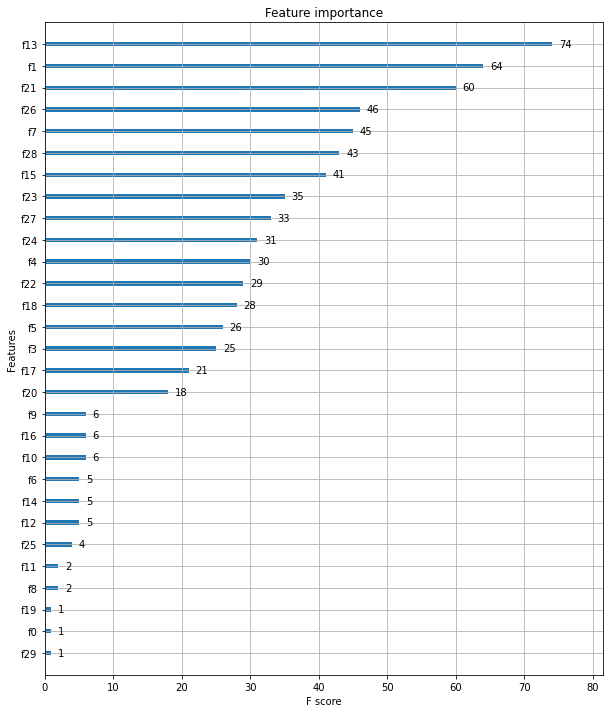

In [21]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_model,ax = ax)

1) `xgboost.cv` : 데이터 세트에 대한 교차 검증 수행

      xgboost.cv(params,dtrain,num_boost_round = 10, nfold = 3, stratified = False, folds = None, metrics= (), obj = None, feval = None, 
      maximize = False, early_stopping_rounds = None, fpreproc = None, as_pandas = True, verbose_eval = None, show_stdv = True, seed = 0, 
      callbacks = None, shuffle = True)

* `params` : 부스터 파라미터
* `dtrain` : 학습 데이터
* `num_boost_round (int)` : 부스팅 반복 횟수
* `nfold(int)` : CV 폴드 개수
* `stratified (bool)` : CV 수행 시 층화 표본 추출 수행 여부
* `metrics` : CV 수행 시 모니터닝할 성능 평가 지표
* `early_stopping_rounds` : 조기 중단을 활성화시킴


## 4. 사이킷런 래퍼 XGBoost의 개요 및 적용
: 파이썬 래퍼와 사이킷런 래퍼의 하이퍼 파라미터에 차이가 있음

* `eta` -> `learing_rate`
* `sub_sample` -> `subsample`
* `lambda` -> `reg_lambda`
* `alpha` -> `reg_alpha`

In [22]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train,y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [24]:
#모델의 예측 성능 평가
get_clf_eval(y_test,w_preds,w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.973684, 정밀도 : 0.974359, 재현율 : 0.987013,F1 : 0.980645, AUC :0.995086


1) 조기 중단 관련 파라미터
* `early_stopping_rounds` : 반복 횟수 정의
* `eval_metric` : 조기 중단을 위한 평가 지표
* `eval_set` : 성능 평가를 수행할 데이터 세트

In [25]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
evals = [(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [26]:
#예측 성능 살펴보기
get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도 : 0.964912, 정밀도 : 0.962025, 재현율 : 0.987013,F1 : 0.974359, AUC :0.995437


In [27]:
#early_stopping_rounds를 10으로 설정하고 재 학습
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds = 10, eval_metric= 'logloss', eval_set = evals, verbose = True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws10_preds,ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


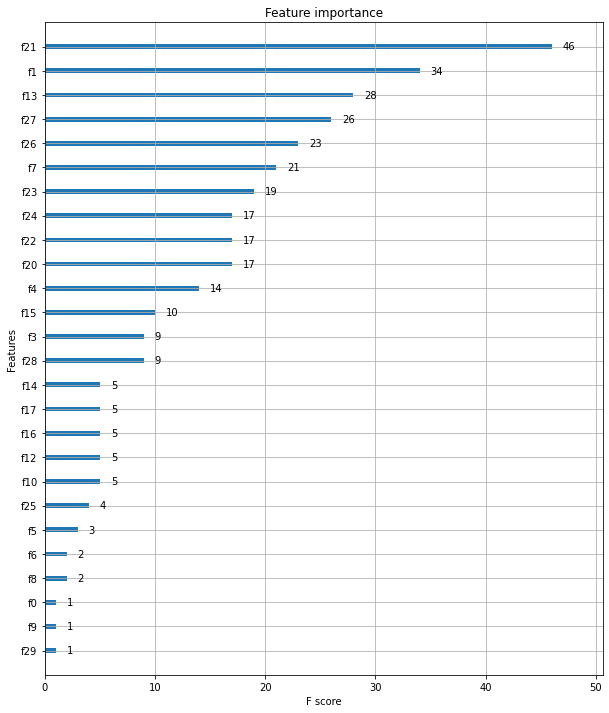

In [30]:
#피처 중요도 시각화

from xgboost import plot_importance
import matplotlib.pyplot as plt


fig,ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_wrapper,ax = ax)

---
# **07 LightGBM**


- XGBoost보다 학습에 걸리는 시간 **훨씬 적음**
- 적은 데이터 세트에 적용할 경우 **과적합**이 발생하기 쉬움






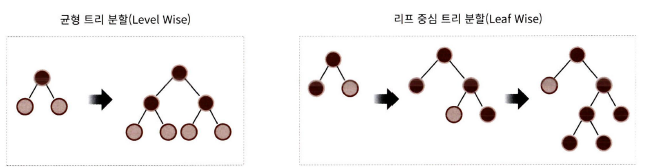

1) 일반 GBM 계열의 트리 분할 방법과 다르게 **리프 중심 트리 분할 방식** 사용

: 트리의 균형을 맞추지 않고, 최대 손실 값을 가지는 리프 노트를 지속적으로 분할
->  트리 깊이가 **깊어지고**, **비대칭적**인 규칙 트리 생성

2) XGBoost 대비 장점
* 더 빠른 학습과 예측 수행 시간
* 더 작은 메모리 사용량
* 카테고리형 피처의 자동 변환과 최적 분할

## 1. LightGBM 하이퍼 파라미터

**1) 주요 파라미터**
* `num_iterations[default=100]` : 반복 수행하려는 트리의 개수 지정
* `learning_rate [default = 0.1]` : 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값
* `max_depth default = -1]` : 트리 기반 알고리즘의 max_depth
* `min_data_in_leaf [default = 20]` : 결정 트리의 min_samples_leaf
* `num_leaves [ default = 31]` : 하나의 트리가 가질 수 있는 최대 리프 개수 
* `boosting [ default = gbdt]` : 부스팅의 트리를 생성하는 알고리즘 기술
* `bagging_fraction [ default = 1.0]` : 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율
* `feature_fraction [default=1.0]` : 개별 트리를 학습할 때마다 무직위로 선택하는 피처의 비율
* `lambda_l2 [ default=0.0]` : L2 regulation 제어를 위한 값
* `lambda_l1[default = 0.0]` : L1 regulation제어를 위한 값

**2) Learning Task 파라미터**
* `objective` : 최솟값을 가져야 할 손실함수 정의


## 2. 하이퍼 파라미터 튜닝 방안

* `num_leaves` : 모델의 복잡도 제어/ **낮아지면 정확도 높아짐 <-> 높아지면 복잡도가 커져 과적합 영향도 커짐**
* `min_data_in_leaf` : **큰 값**으로 설정하면 트리가 깊어지는 것을 방지
* `max_depth` : 깊이의 크기 제한

## 3. 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교

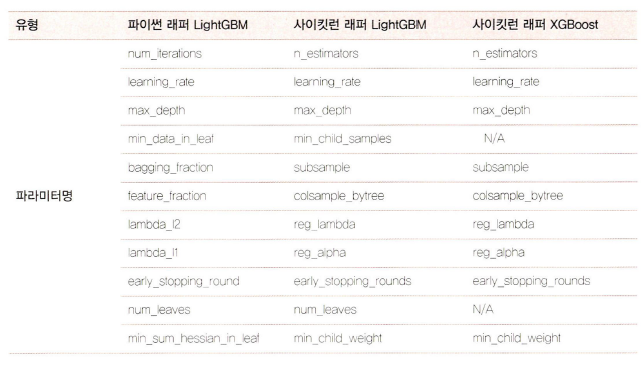

## 4. LightGBM 적용 - 위스콘신 유방암 예측

In [33]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

datasets = load_breast_cancer()
ftr = datasets.data
target = dataset.target

X_train,X_test,y_train,y_test = train_test_split(ftr,target,test_size = 0.2, random_state = 156)

lgbm_wrapper = LGBMClassifier(n_estimators = 400)
evals = [(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [34]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도 : 0.947368, 정밀도 : 0.949367, 재현율 : 0.974026,F1 : 0.961538, AUC :0.992629


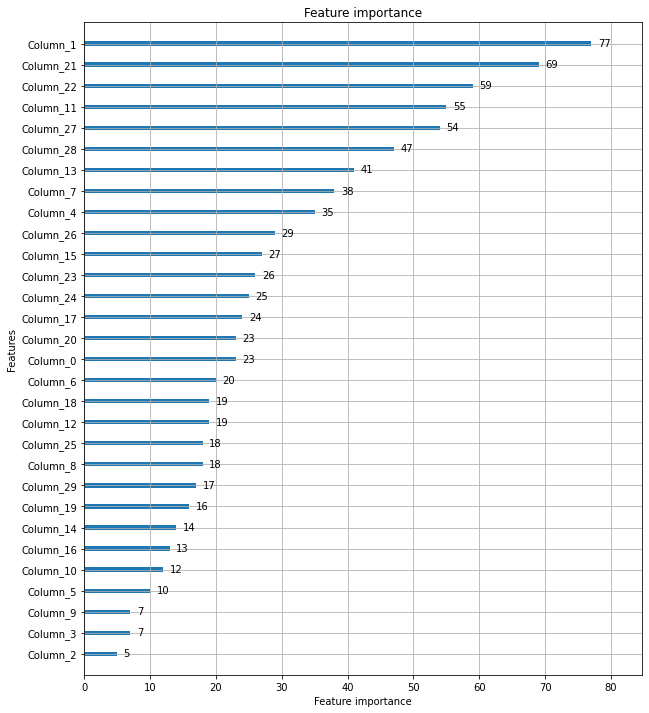

In [35]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize = (10,12))
plot_importance(lgbm_wrapper,ax=ax)

---
# **10 스태킹 앙상블**
: 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측 수행

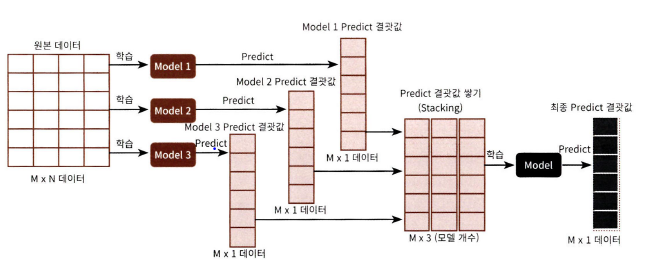

    : M X N 데이터 세트에 적용한다고 가정

    (1) 학습에 사용할 ML 알고리즘 모델은 모두 3개
    (2) 모델별로 각각 학습을 시킨 뒤 예측 수행
    (3) M개의 로우를 가진 1개의 레이블 값 각각 도출
    (4) 모델별로 도출된 예측 레이블 값을 다시 합해서 새로운 데이터 만들기
    (5) 최종 모델 적용해 최종 예측을 하는 것

## 1. 기본 스태킹 모델


In [37]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train,X_test,y_train,y_test = train_test_split(X_data,y_label,test_size = 0.2,random_state = 0)

In [39]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors = 4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators = 100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

#개별 모델 학습
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100)

In [42]:
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도 : {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도 : {0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도 : {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도 : 0.9211
랜덤 포레스트 정확도 : 0.9649
결정 트리 정확도 : 0.9123
에이다부스트 정확도 : 0.9561


In [43]:
pred = np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [44]:
lr_final.fit(pred,y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도 : 0.9737


## 2. CV 세트 기반의 스태킹
: 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트 이용

**Step 1** 각 모델 별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성

**Step 2**  학습용 데이터를 모두 **스태킹 형태**로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 셑트 생성. 테스트 데이터도 마찬가지. 메타 모델은 최종적으로 생성된 학습 데이터와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최정적으로 생성된 테스트 데이터 세트를 예측하고 **원본 테스트 데이터의 레이블 데이터를 기반으로 평가**

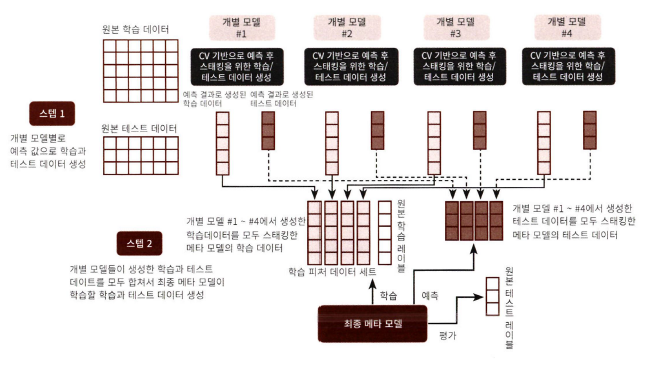

In [48]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트 용 데이터를 생성하기 위한 함수
def get_stacking_base_dataset(model,X_train_n,y_train_n,X_test_n,n_folds) :
  #지정된 n_folds값으로 KFold 생성
  kf = KFold(n_splits = n_folds, shuffle = True, random_state = 0)
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index,valid_index) in enumerate(kf.split(X_train_n)) :
    print('\t 폴드 세트 :', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr,y_tr)
    train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter] = model.predict(X_test_n)
  
  test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1,1)

  return train_fold_pred, test_pred_mean

In [49]:
knn_train,knn_test = get_stacking_base_dataset(knn_clf,X_train,y_train,X_test,7)
rf_train,rf_test = get_stacking_base_dataset(rf_clf,X_train,y_train,X_test,7)
dt_train,dt_test = get_stacking_base_dataset(dt_clf,X_train,y_train,X_test,7)
ada_train,ada_test = get_stacking_base_dataset(ada_clf,X_train,y_train,X_test,7)

KNeighborsClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
RandomForestClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
AdaBoostClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작


In [50]:
#Step 2

Stack_final_X_train = np.concatenate((knn_train,rf_train,dt_train,ada_train),axis = 1)
Stack_final_X_test = np.concatenate((knn_test,rf_test,dt_test,ada_test),axis = 1)
print('원본 학습 피처 데이터 Shape :', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape :', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 Shape :', Stack_final_X_test.shapel)

원본 학습 피처 데이터 Shape : (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape : (455, 4) 스태킹 테스트 피처 데이터 Shape : (114, 4)


In [53]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도 : 0.9649


---
# **11 정리**

1. 앙상블 기법 : 결정 트리 기반의 다수의 약한 학습기를 결합해 변동성을 줄여 예측 오류를 줄이고 성능 개선

  1. 배깅 : 학습 데이터를 중복을 허용하면서 다수의 세트로 샘플링하여 최종 결과를 결합해 예측 ex)랜덤 포레스트
  2. 부스팅 : 학습기들이 순차적으로 학습을 진행하면서 예측이 틀린 데이터에 대해서는 가중치를 부여해 다음번 학습기가 학습할 때에는 이전에 예측이 틀린 데이터에 대해서는 보다 높은 정확도로 예측할 수 있도록 해줌 ex) GBM, XGBoost, LightGBM
  3. 스태킹 모델 : 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 세트를 재 생성하는 기법



